# 🏦 Banking Churn Prediction - End-to-End Analysis

This notebook performs a full end-to-end **Banking Customer Churn Analysis** using synthetic data.

### Steps included:
1. Generate a synthetic banking dataset (with duplicates and missing values)
2. Perform Exploratory Data Analysis (EDA)
3. Clean the data (handle duplicates and missing values)
4. Build preprocessing pipelines
5. Train and compare multiple machine learning models (Logistic Regression, Random Forest, Gradient Boosting)
6. Evaluate and visualize performance (ROC curves, confusion matrix, feature importance)
7. Predict future churn probabilities for new customers
8. Save cleaned datasets and model results

---


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Create output directory
OUT_DIR = os.path.join(os.getcwd(), 'bank_churn_outputs')
os.makedirs(OUT_DIR, exist_ok=True)


In [4]:
# 1️⃣ Generate synthetic dataset
def generate_synthetic_bank_churn(n_customers=5000, seed=RANDOM_STATE):
    np.random.seed(seed)
    customerID = [f"C{100000+i}" for i in range(n_customers)]
    geography = np.random.choice(['France','Spain','Germany'], size=n_customers, p=[0.5,0.3,0.2])
    gender = np.random.choice(['Male','Female'], size=n_customers)
    age = np.random.randint(18, 92, size=n_customers)
    tenure = np.random.randint(0, 11, size=n_customers)
    balance = np.round(np.random.exponential(scale=70000, size=n_customers),2)
    num_products = np.random.choice([1,2,3,4], size=n_customers, p=[0.7,0.2,0.08,0.02])
    has_cr_card = np.random.choice([0,1], size=n_customers, p=[0.3,0.7])
    is_active_member = np.random.choice([0,1], size=n_customers, p=[0.4,0.6])
    estimated_salary = np.round(np.random.normal(60000, 30000, size=n_customers),2)
    credit_score = np.clip(np.random.normal(650, 70, size=n_customers).astype(int), 350, 850)

    risk_score = (
        (700 - credit_score)/200 +
        (is_active_member==0).astype(int)*0.3 +
        (num_products==1).astype(int)*0.15 +
        (balance < 10000).astype(int)*0.15 +
        (age < 25).astype(int)*0.05 +
        (age > 75).astype(int)*0.05
    )
    prob_churn = np.clip(risk_score, 0, 1)
    churn = (np.random.rand(n_customers) < prob_churn).astype(int)

    return pd.DataFrame({
        'CustomerID': customerID,
        'Geography': geography,
        'Gender': gender,
        'Age': age,
        'Tenure': tenure,
        'Balance': balance,
        'NumOfProducts': num_products,
        'HasCrCard': has_cr_card,
        'IsActiveMember': is_active_member,
        'EstimatedSalary': estimated_salary,
        'CreditScore': credit_score,
        'Churn': churn
    })

df = generate_synthetic_bank_churn()
print('✅ Synthetic data generated:', df.shape)


✅ Synthetic data generated: (5000, 12)


In [5]:

# 2️⃣ Inject duplicates & missing values
def inject_issues(df, dup_frac=0.05, missing_columns=None, missing_frac=0.10):
    np.random.seed(43)
    df_copy = df.copy()
    n = len(df_copy)
    n_dup = int(n * dup_frac)
    df_copy = pd.concat([df_copy, df_copy.sample(n_dup, random_state=43)], ignore_index=True)
    if missing_columns is None:
        missing_columns = ['CreditScore','Balance','EstimatedSalary','Geography','Gender']
    for col in missing_columns:
        mask = np.random.rand(len(df_copy)) < missing_frac
        df_copy.loc[mask, col] = np.nan
    return df_copy

df_with_issues = inject_issues(df)
print('✅ Duplicates & missing values added:', df_with_issues.shape)

noisy_csv_path = os.path.join(OUT_DIR, 'bank_churn_with_issues.csv')
df_with_issues.to_csv(noisy_csv_path, index=False)


✅ Duplicates & missing values added: (5250, 12)


In [6]:

# 3️⃣ EDA
print('\nMissing values per column:\n', df_with_issues.isnull().sum())
print('\nDuplicate count:', df_with_issues.duplicated().sum())
print('\nData sample:\n', df_with_issues.head())


Missing values per column:
 CustomerID           0
Geography          513
Gender             485
Age                  0
Tenure               0
Balance            515
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    531
CreditScore        515
Churn                0
dtype: int64

Duplicate count: 102

Data sample:
   CustomerID Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0    C100000    France    Male   69       9   74034.37              1   
1    C100001   Germany  Female   21       1   52340.45              2   
2    C100002     Spain    Male   51       9   14249.35              1   
3    C100003     Spain  Female   86       6  149745.27              1   
4    C100004       NaN  Female   50       9   29431.48              2   

   HasCrCard  IsActiveMember  EstimatedSalary  CreditScore  Churn  
0          0               1         90652.37        650.0      0  
1          1               0         41069.91        802.0      0  
2 

In [7]:
# 4️⃣ Data Cleaning
df_clean = df_with_issues.drop_duplicates().reset_index(drop=True)


In [9]:

# Split data
TARGET = 'Churn'
features = [c for c in df_clean.columns if c not in ['CustomerID', TARGET]]
X_train, X_test, y_train, y_test = train_test_split(df_clean[features], df_clean[TARGET],
                                                    test_size=0.3, stratify=df_clean[TARGET],
                                                    random_state=RANDOM_STATE)

num_features = ['Age','Tenure','Balance','NumOfProducts','EstimatedSalary','CreditScore']
cat_features = ['Geography','Gender','HasCrCard','IsActiveMember']

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer([('num', numeric_transformer, num_features),
                                  ('cat', categorical_transformer, cat_features)])

In [10]:


# 5️⃣ Model Training & Comparison
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE)
}

results = []
probas = {}
for name, model in models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:,1]
    y_pred = (y_proba >= 0.5).astype(int)
    probas[name] = y_proba
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_proba)
    })

results_df = pd.DataFrame(results).sort_values('ROC_AUC', ascending=False)
print('\n📊 Model Comparison:\n', results_df)

best_model = results_df.iloc[0]['Model']
print(f'🏆 Best Model: {best_model}')




📊 Model Comparison:
                 Model  Accuracy  Precision    Recall        F1   ROC_AUC
0  LogisticRegression  0.741100   0.759259  0.724747  0.741602  0.844135
2    GradientBoosting  0.744337   0.757458  0.737374  0.747281  0.840740
1        RandomForest  0.746278   0.749377  0.758838  0.754078  0.833613
🏆 Best Model: LogisticRegression


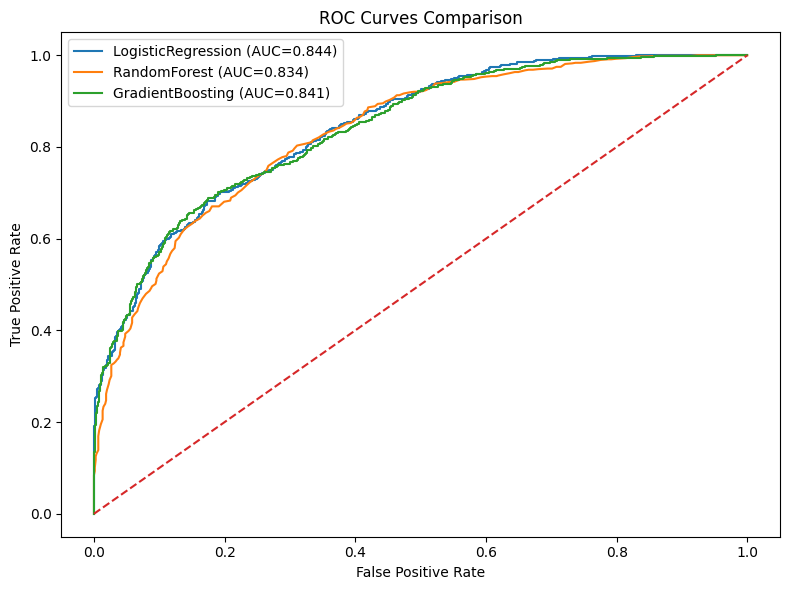

In [11]:
# 6️⃣ Visualization
plt.figure(figsize=(8,6))
for name, y_proba in probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.tight_layout()
plt.show()


🧭 Future Predictions:
   CustomerID  Churn_Prob
0       NEW1    0.202110
1       NEW2    0.124326
2       NEW3    0.155721
3       NEW4    0.013735
4       NEW5    0.996892
5       NEW6    0.905711
6       NEW7    0.950544
7       NEW8    0.044344
8       NEW9    0.992948
9      NEW10    0.304364


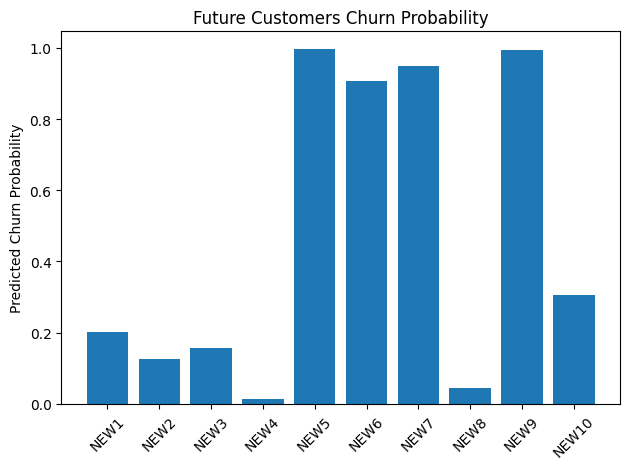

In [12]:

# 7️⃣ Future Prediction
new_customers = pd.DataFrame({
    'CustomerID': [f'NEW{i+1}' for i in range(10)],
    'Geography': np.random.choice(['France','Spain','Germany'],10),
    'Gender': np.random.choice(['Male','Female'],10),
    'Age': np.random.randint(20,80,10),
    'Tenure': np.random.randint(0,10,10),
    'Balance': np.random.uniform(0,100000,10),
    'NumOfProducts': np.random.randint(1,4,10),
    'HasCrCard': np.random.choice([0,1],10),
    'IsActiveMember': np.random.choice([0,1],10),
    'EstimatedSalary': np.random.uniform(30000,120000,10),
    'CreditScore': np.random.randint(400,850,10)
})

pipe = Pipeline([('preprocessor', preprocessor), ('clf', models[best_model])])
pipe.fit(X_train, y_train)
new_customers['Churn_Prob'] = pipe.predict_proba(new_customers.drop(columns=['CustomerID']))[:,1]
print('\n🧭 Future Predictions:\n', new_customers[['CustomerID','Churn_Prob']])

plt.bar(new_customers['CustomerID'], new_customers['Churn_Prob'])
plt.xticks(rotation=45)
plt.ylabel('Predicted Churn Probability')
plt.title('Future Customers Churn Probability')
plt.tight_layout()
plt.show()
